In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import os
import matplotlib.pyplot as plt
import tqdm
import numpy as np

os.chdir("../src")
import simulator

In [282]:
S = simulator.Simulator(
    Ne = 10000,
    s = 0,
    Un = 2e-4,
    Ud = 2e-4,
    n_generations = 20000,
    random_seed = 42,
)

S.run()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19999/19999 [09:26<00:00, 35.28it/s]


(0.0, 1000.0)

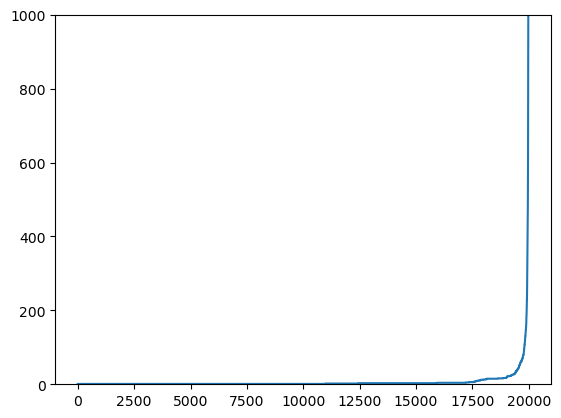

In [283]:
plt.plot([len(x) for x in S.ancestors])
plt.ylim(0, 1000)

(0.0, 20.0)

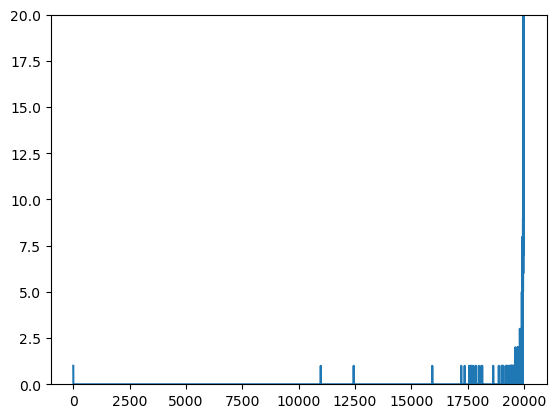

In [288]:
import math

plt.plot(
    np.diff([len(x) for x in S.ancestors], prepend=0)
)
plt.ylim(0,20)

/tmp/ipykernel_2944751/1084442451.py:4: RuntimeWarning: divide by zero encountered in divide
  (np.diff([len(x) for x in S.ancestors], prepend=0) / np.array([math.comb(len(x), 2) for x in S.ancestors])).reshape((5000, -1)).mean(axis=0)
/tmp/ipykernel_2944751/1084442451.py:4: RuntimeWarning: invalid value encountered in divide
  (np.diff([len(x) for x in S.ancestors], prepend=0) / np.array([math.comb(len(x), 2) for x in S.ancestors])).reshape((5000, -1)).mean(axis=0)


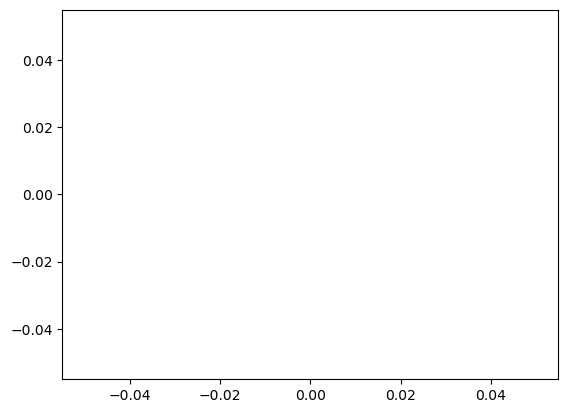

In [285]:
import math

plt.plot(
    (np.diff([len(x) for x in S.ancestors], prepend=0) / np.array([math.comb(len(x), 2) for x in S.ancestors])).reshape((5000, -1)).mean(axis=0)
)